In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from healpy import projview
from icecube_tools.utils.data import RealEvents, SimEvents
from icecube_tools.point_source_analysis.point_source_analysis import MapScan
import h5py

## Idea to parallelise in a sensible fashion

Set npix/nside to the desired angular resolution and generate sources. Split sources into reasonable length parts, e.g. 1000 sources, meaning `MapScan().test_ra = MapScan().test_ra[n*1000:(n+1)*1000]`. Then write config with distinct name. Repeat until all sources are in mentioned in a config.

Read in configs in parallel processes, calculate, write output again with same distinct identifier.

Make script reading in all result files.

In [2]:
events = RealEvents.from_event_files()

In [9]:
scan = MapScan("config.yaml", events, "skymap_ngc_restricted.hdf5")

In [4]:
events.periods

['IC40', 'IC59', 'IC79', 'IC86_I', 'IC86_II']

In [8]:
r = np.deg2rad(np.linspace(38, 42, num=11))
d = np.deg2rad(np.linspace(-2, 2, num=11))
rr, dd = np.meshgrid(r, d)
rr = rr.flatten()
dd = dd.flatten()
print(rr.size)

121


In [19]:
r, d

(array([0.66322512, 0.67020643, 0.67718775, 0.68416907, 0.69115038,
        0.6981317 , 0.70511302, 0.71209433, 0.71907565, 0.72605697,
        0.73303829]),
 array([-0.03490659, -0.02792527, -0.02094395, -0.01396263, -0.00698132,
         0.        ,  0.00698132,  0.01396263,  0.02094395,  0.02792527,
         0.03490659]))

In [10]:
scan.generate_sources()
scan.ts.shape

INFO:icecube_tools.point_source_analysis.point_source_analysis:resolution in degrees: 0.9161297098179749


(49152,)

In [7]:
scan.ts.max()

0.0

In [11]:
scan.perform_scan(show_progress=True)

INFO:icecube_tools.point_source_analysis.point_source_analysis:Performing scan for periods: ['IC40', 'IC59', 'IC79', 'IC86_I', 'IC86_II']
  0%|          | 0/49152 [00:00<?, ?it/s]

'MapScan' object has no attribute 'likelihood'
Reloading likelihood object


/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:72: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:72: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:72: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
/home/iwsatlas1/kuhlmann/icecube/icecube_tools/icecube_tools/detector/r2021.py:72: RuntimeWarning: divide by zero encountered in log10
  self.dataset[:, 6:-1] = np.log10(self.dataset[:, 6:-1])
100%|██████████| 49152/49152 [00:39<00:00, 1255.88it/s]


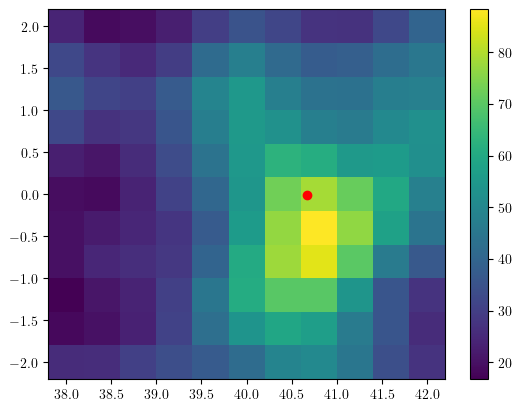

In [16]:
fig, ax = plt.subplots()
pcol = ax.pcolormesh(np.rad2deg(r), np.rad2deg(d), scan.ts.reshape((11, 11)), shading="nearest")
fig.colorbar(pcol, ax=ax)
ax.scatter(40.6696215289200, -00.0132943583900, c="red")

In [26]:
scan.ra_test[scan.ts.argmax()], scan.dec_test[scan.ts.argmax()]

(0.7120943348136864, -0.006981317007977317)

In [10]:
f["output/ts"][()]

array([38.10039364, 54.96211889, 24.3751548 , 55.73964628])

In [17]:
for p in events.periods: 
    ra = events.ra[p]
    dec = events.dec[p]
    print(events.reco_energy[p][np.nonzero(((ra > np.deg2rad(35)) & (ra < np.deg2rad(45)) & (dec < np.deg2rad(5)) & (ra > np.deg2rad(-5))))].min())

912.0108393559096
870.9635899560806
794.3282347242813
151.35612484362088
33.11311214825911


In [13]:
import os

In [16]:
os.path.join(os.path.splitext("tsmap.ipynb")[0], ".yaml")

'tsmap/.yaml'

In [25]:
np.savez("ngc_ts.npz", scan.ts)

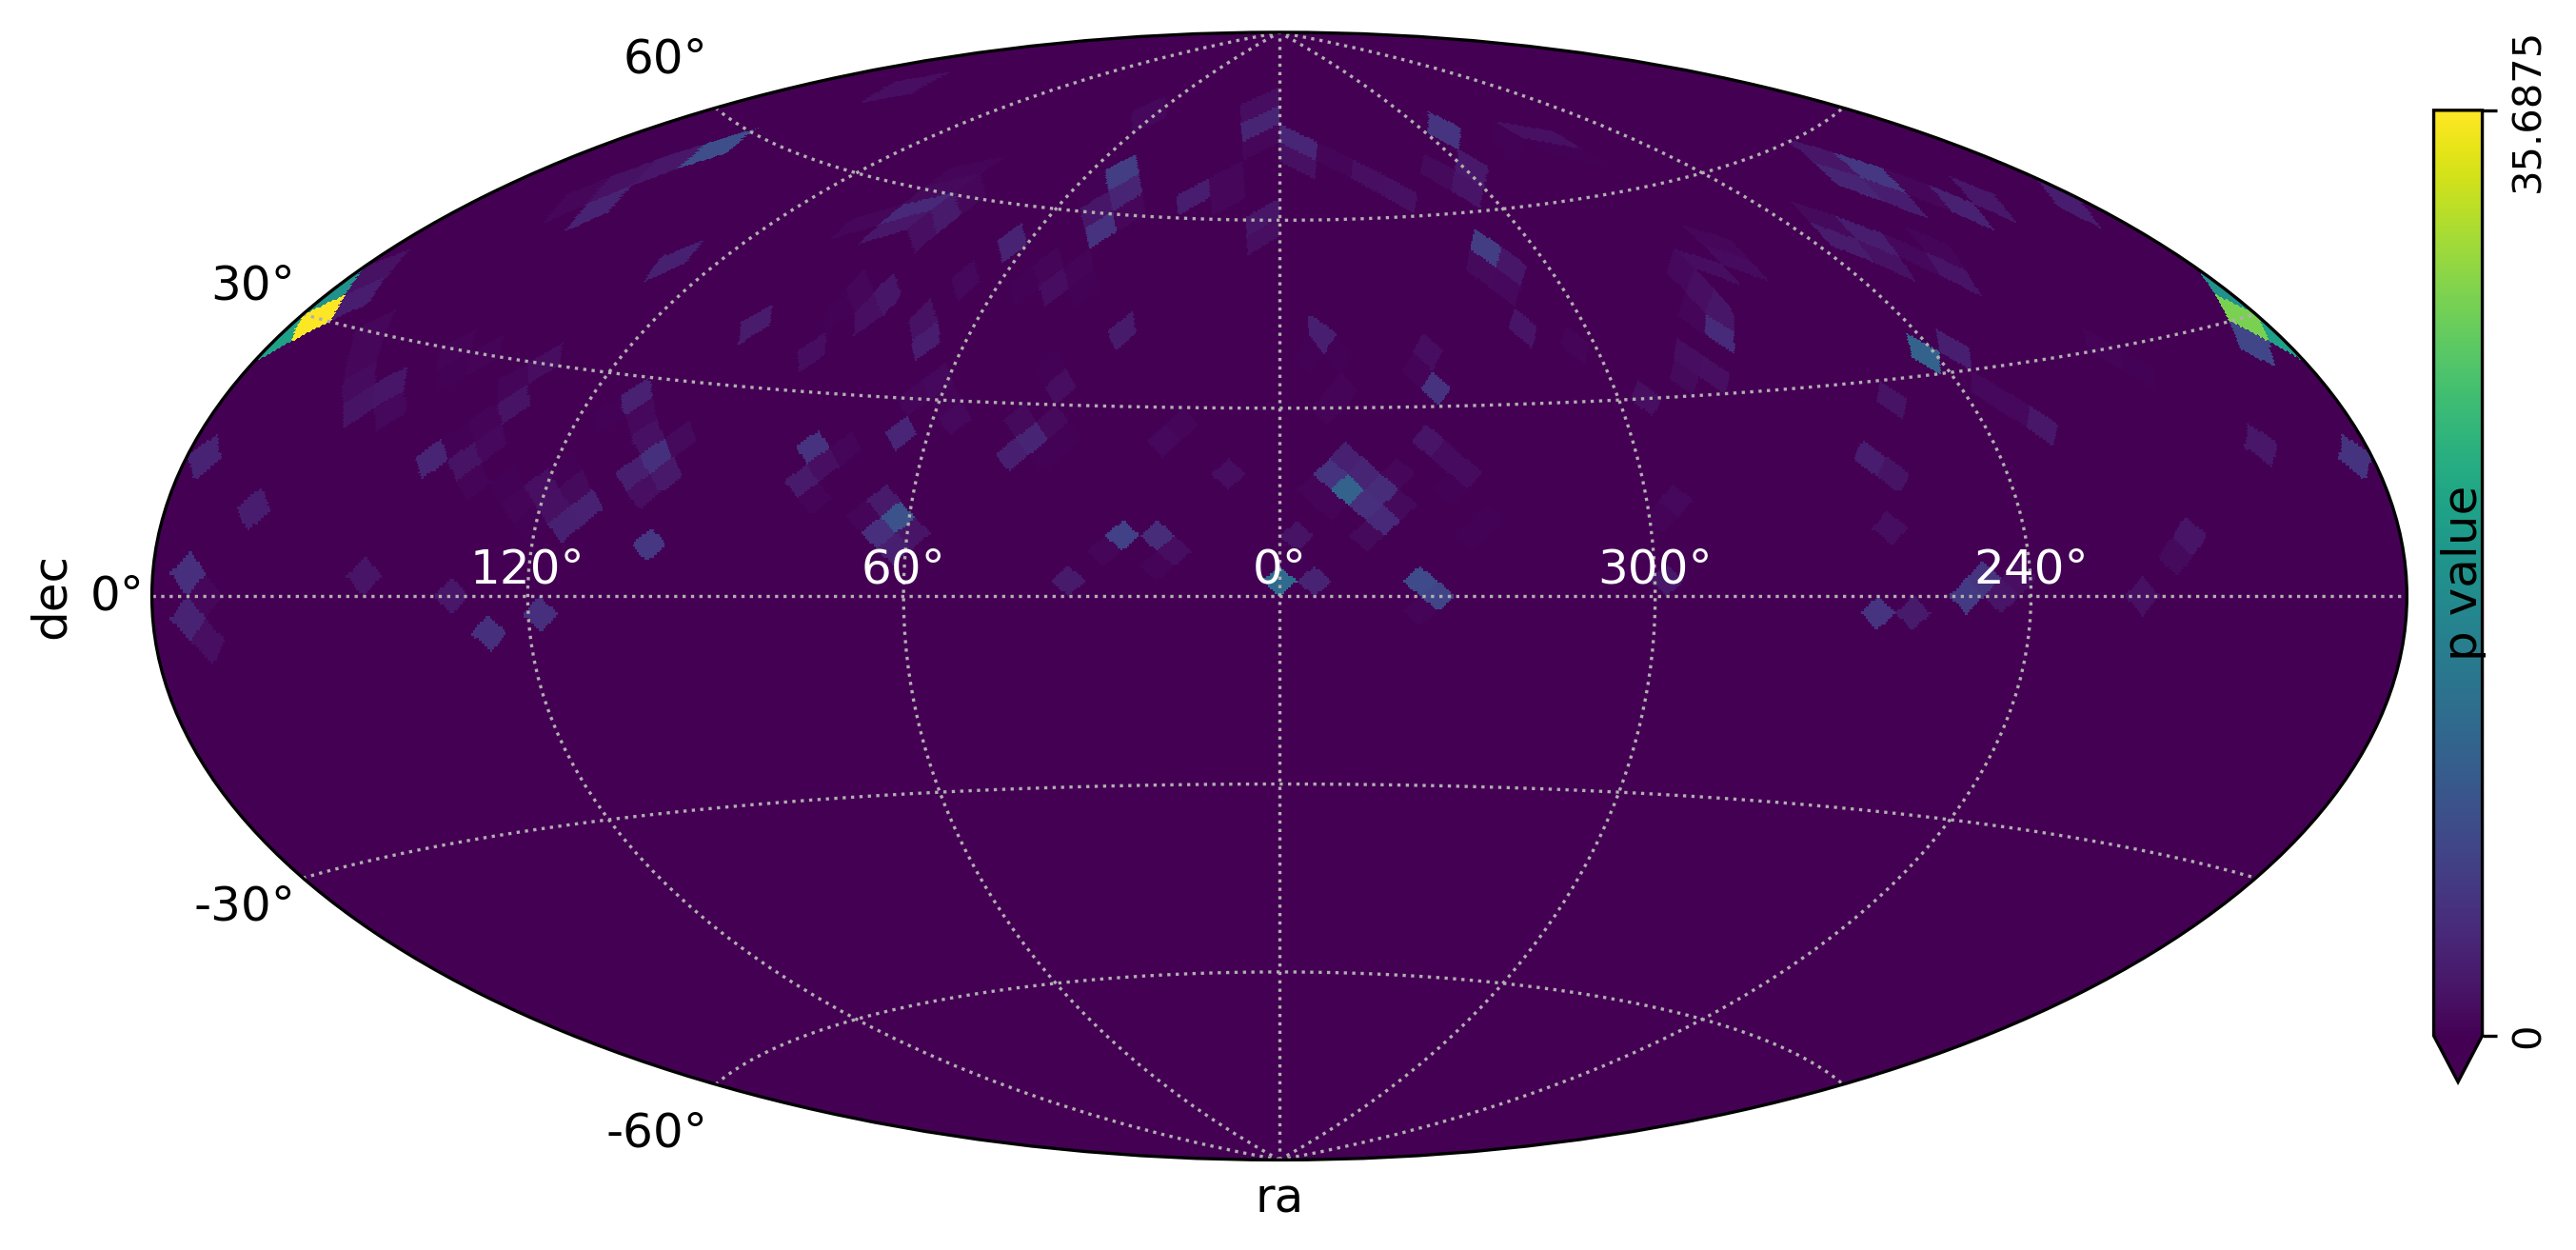

In [21]:
projview(
    scan.ts,
    coord=["G"],
    graticule=True,
    graticule_labels=True,
    unit="p value",
    xlabel="ra",
    ylabel="dec",
    min=0,
    max=scan.ts.max(),
    cmap='viridis',
    cb_orientation="vertical",
    projection_type="aitoff",
);
plt.xticks(color="white")
plt.grid(ls=':')
plt.savefig("test_data.png")

In [11]:
ev = SimEvents.load_from_h5("/Users/David/Documents/phd/icecube/icecube_tools/docs/markdown/h5_test.hdf5")

In [18]:
scan.ns.shape

(121, 5)

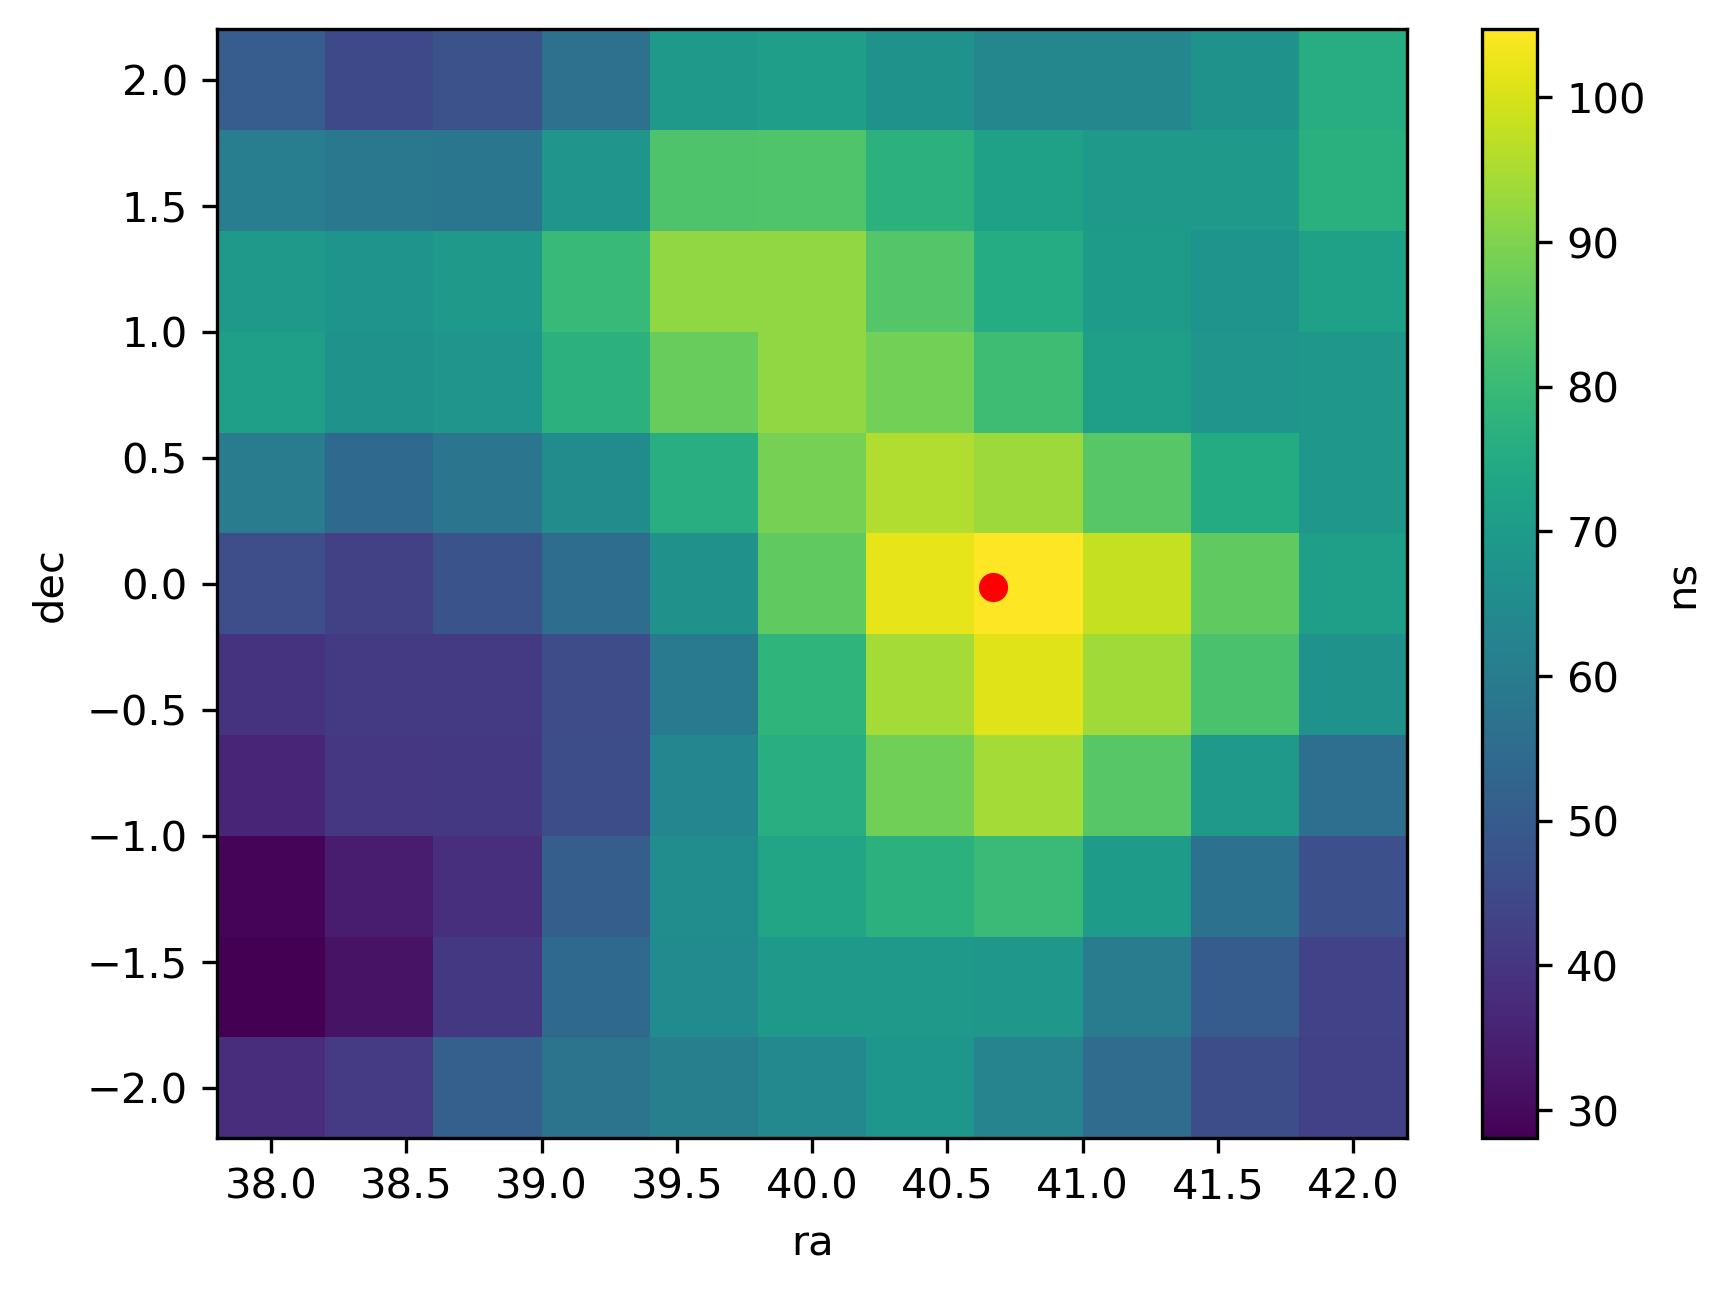

In [15]:
fig, ax = plt.subplots()
pcol = ax.pcolormesh(np.rad2deg(r), np.rad2deg(d), scan.ns.reshape((11, 11)), shading="nearest")
ax.scatter(40.6696215289200, -00.0132943583900, c="red")
ax.set_xlabel("ra")
ax.set_ylabel("dec")
cbar = fig.colorbar(pcol)
cbar.set_label("ns")
fig.savefig("ngc_1068_ns.png")

In [28]:
ts = scan.ts

In [33]:
ts[:15], rr[:15]

(array([17.97053111, 31.07059748, 42.28009901, 44.29810258, 42.60181248,
        43.84997448, 50.46108743, 47.9466259 , 37.29362681, 28.22325534,
        26.54400871, 20.26722875, 30.19978029, 40.33409612, 49.02698803]),
 array([0.66322512, 0.67020643, 0.67718775, 0.68416907, 0.69115038,
        0.6981317 , 0.70511302, 0.71209433, 0.71907565, 0.72605697,
        0.73303829, 0.66322512, 0.67020643, 0.67718775, 0.68416907]))

In [35]:
ts.reshape((11, 11))[:15], rr.reshape((11, 11))[:15]

(array([[ 17.97053111,  31.07059748,  42.28009901,  44.29810258,
          42.60181248,  43.84997448,  50.46108743,  47.9466259 ,
          37.29362681,  28.22325534,  26.54400871],
        [ 20.26722875,  30.19978029,  40.33409612,  49.02698803,
          47.71460597,  40.72789935,  34.87457022,  32.19920787,
          28.34406109,  22.65042241,  21.16141206],
        [ 25.38656708,  32.85880343,  40.53402457,  50.39764509,
          49.92441274,  40.57035879,  32.76691956,  30.8650407 ,
          26.12194433,  22.32583926,  20.19816291],
        [ 32.93704854,  38.56225853,  40.35165867,  44.8958887 ,
          48.08919167,  45.98674125,  50.18167578,  53.67543509,
          46.47198966,  38.10458245,  31.24180128],
        [ 36.72212172,  39.53044463,  39.36797883,  41.25415673,
          47.32738399,  57.50689583,  74.74916684,  85.35123099,
          78.45703372,  64.53401574,  48.81169296],
        [ 39.71422395,  38.09366284,  41.05728021,  46.1803522 ,
          56.42368379,  7

In [58]:
scan.ns.sum(axis=-1), np.sqrt(np.sum(scan.ns_err**2, axis=-1))

(array([ 64.56801628,  90.56707108,  98.91882307, 115.3255976 ,
         90.33317565,  75.23661347,  65.63414258,  85.23466696,
        107.80243863, 126.3493444 , 111.75760577,  83.56840884,
         83.97276109,  81.4207549 , 102.79212213, 160.75104684,
        172.91410327, 131.3887627 , 107.7035214 , 102.05318929,
        125.73349136, 165.97269084, 170.26325518, 145.64281975,
        109.599177  , 120.94819683, 157.05873567, 166.852856  ,
        158.53697626, 152.01909601,  89.86686508,  93.41077863,
        139.93857814, 151.33608137, 155.30848553, 150.10921286]),
 array([24.57430222, 26.60223551, 17.51086037, 17.65867595, 17.93507122,
        14.05257252, 16.39529123, 17.66532373, 18.00533484, 19.15824713,
        18.42473518, 15.91528016, 39.57864553, 24.41546662, 18.61035353,
        21.50125745, 22.16471238, 20.5837128 , 20.52768105, 19.91123672,
        22.70447244, 22.25527369, 23.1007587 , 22.53858099, 21.08098486,
        20.93108575, 21.74407212, 23.78405655, 23.1319756

In [59]:
scan.likelihood

AttributeError: 'MapScan' object has no attribute 'likelihood'

In [10]:
f = h5py.File("output.hdf5", "w")

In [11]:
group = f.create_group("meta")

In [12]:
group.name

'/meta'

In [18]:
group.create_dataset("data", data = np.arange(5))

<HDF5 dataset "data": shape (5,), type "<i8">

In [20]:
group.create_dataset("path", data=np.array(["path.yaml"], dtype=str))

TypeError: No conversion path for dtype: dtype('<U9')

In [18]:
group["path"][()]

b'path.yaml'

In [25]:
group.attrs["path"] = "some_path.yaml"

In [29]:
group.attrs["path"]

'some_path.yaml'